In [2]:
# prompt: read csv file from google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CS5242_Song_Prediction/spotify_songs.csv")

# Shape and column types
print("Dataset Shape:", df.shape)
print("\nColumn Types:\n", df.dtypes)

# Count missing values
print("\nMissing Values:\n", df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)

# Check for placeholder lyrics
placeholder = "Lyrics for this song have yet to be released. Please check back once the song has been released."
num_placeholder = df['lyrics'].fillna("").str.contains(placeholder).sum()
print("\nNumber of placeholder lyrics:", num_placeholder)

Dataset Shape: (18454, 25)

Column Types:
 track_id                     object
track_name                   object
track_artist                 object
lyrics                       object
track_popularity              int64
track_album_id               object
track_album_name             object
track_album_release_date     object
playlist_name                object
playlist_id                  object
playlist_genre               object
playlist_subgenre            object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                   int64
language                     object
dtype: object

Missing Values:
 track_id                 

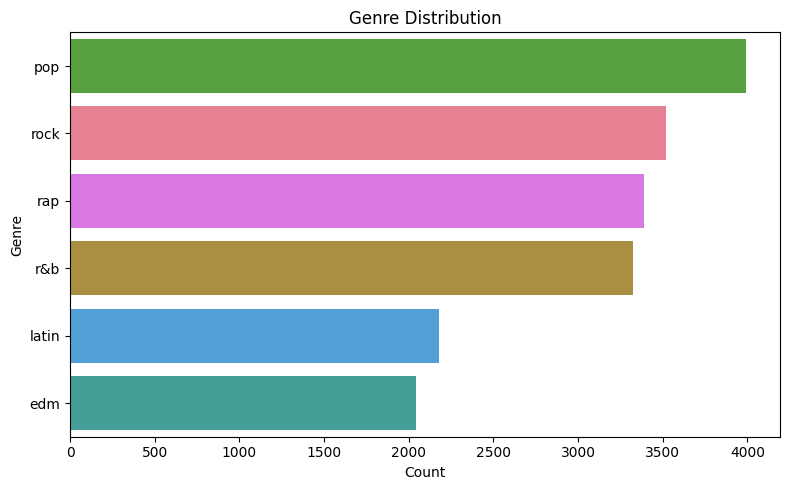

In [21]:
# Genre distribution
plt.figure(figsize=(8, 5))
sns.countplot(y="playlist_genre", data=df, order=df['playlist_genre'].value_counts().index, hue="playlist_genre")
plt.title("Genre Distribution")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

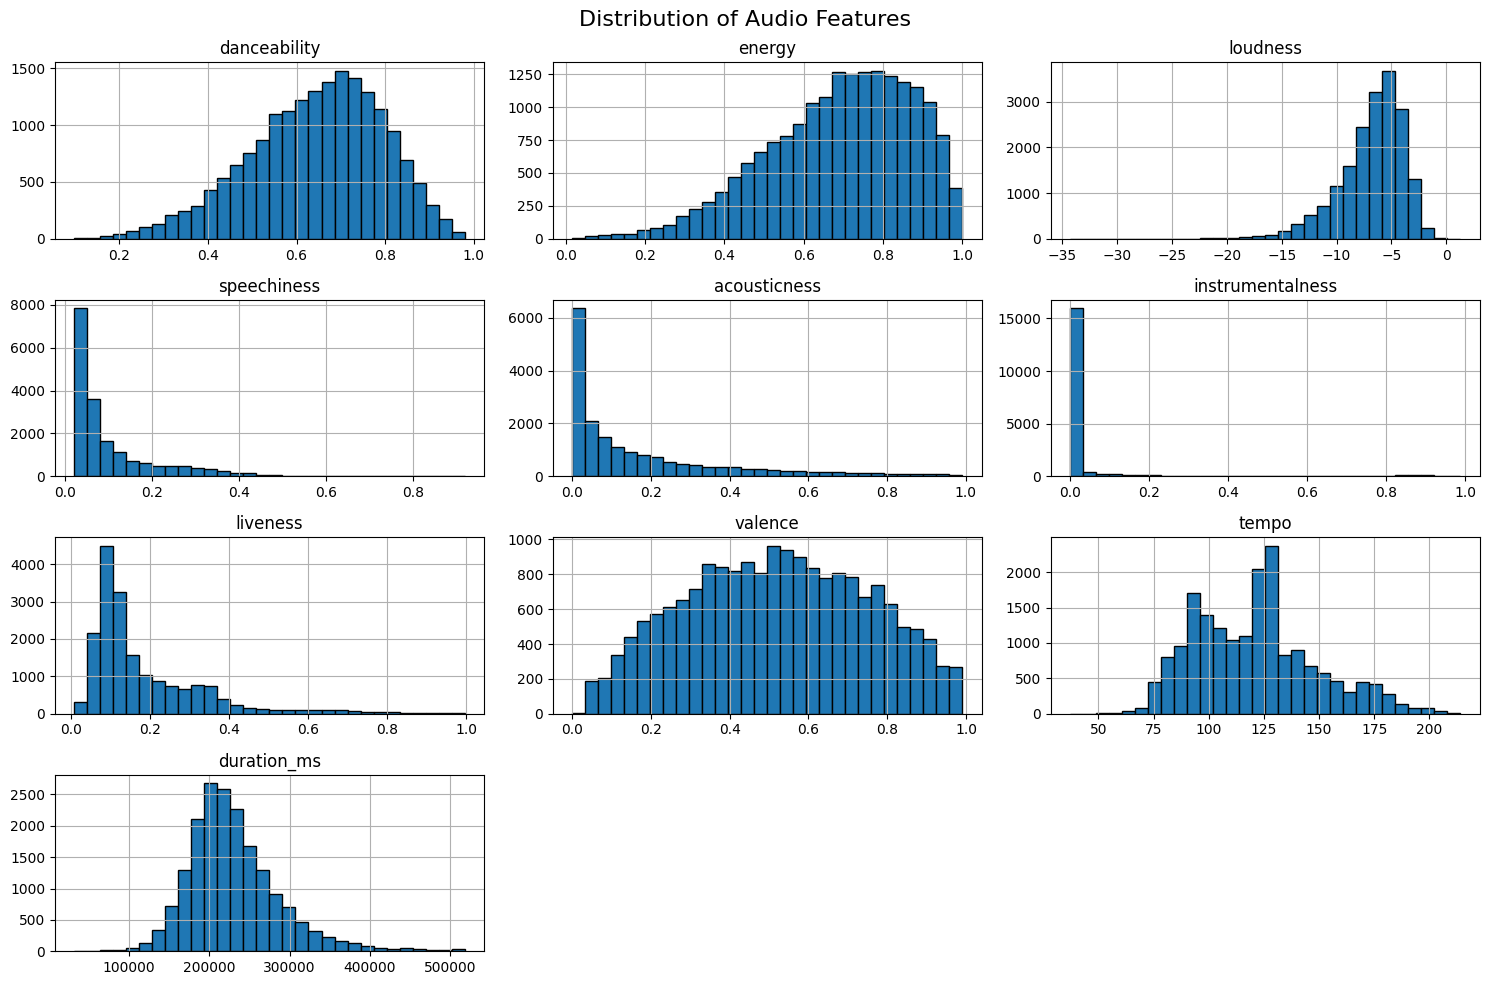

In [5]:
# Audio feature distributions
audio_cols = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'
]

df[audio_cols].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle("Distribution of Audio Features", fontsize=16)
plt.tight_layout()
plt.show()

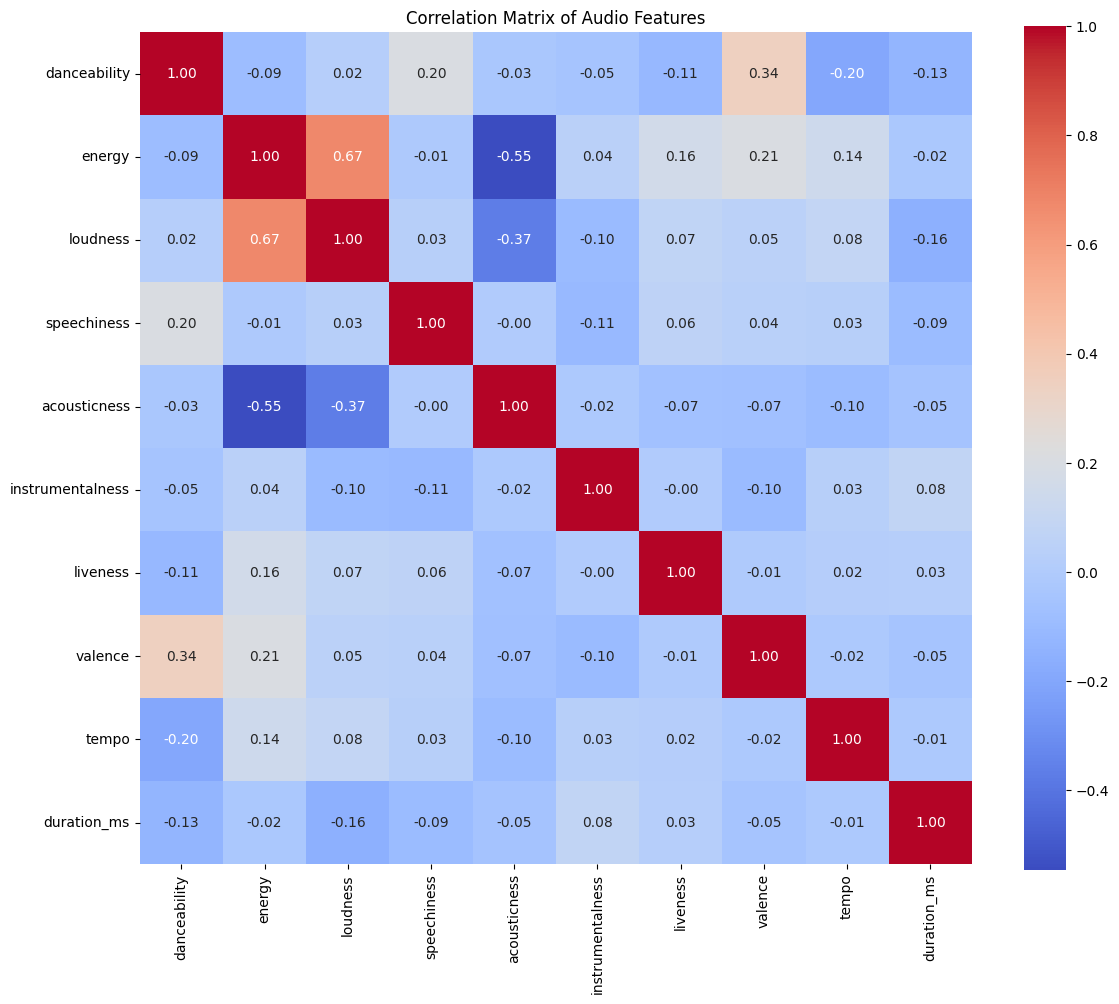

In [6]:
# Correlation matrix
plt.figure(figsize=(12, 10))
corr = df[audio_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Audio Features")
plt.tight_layout()
plt.show()

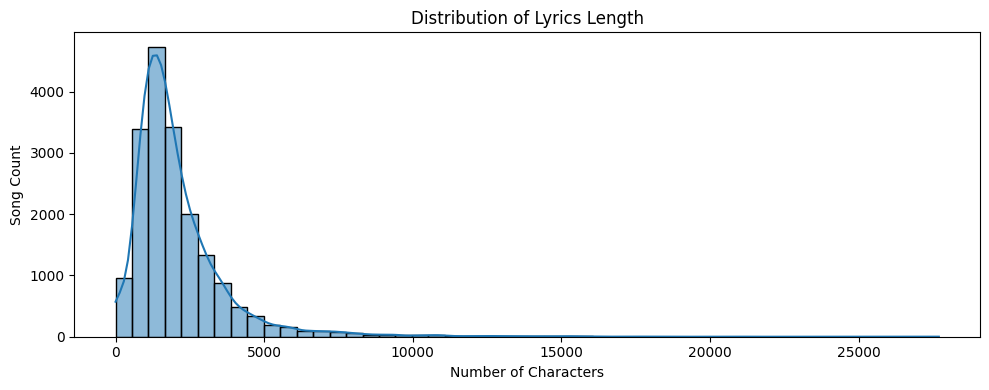

In [7]:
# Lyrics length
df['lyrics_length'] = df['lyrics'].fillna("").apply(len)
plt.figure(figsize=(10, 4))
sns.histplot(df['lyrics_length'], bins=50, kde=True)
plt.title("Distribution of Lyrics Length")
plt.xlabel("Number of Characters")
plt.ylabel("Song Count")
plt.tight_layout()
plt.show()

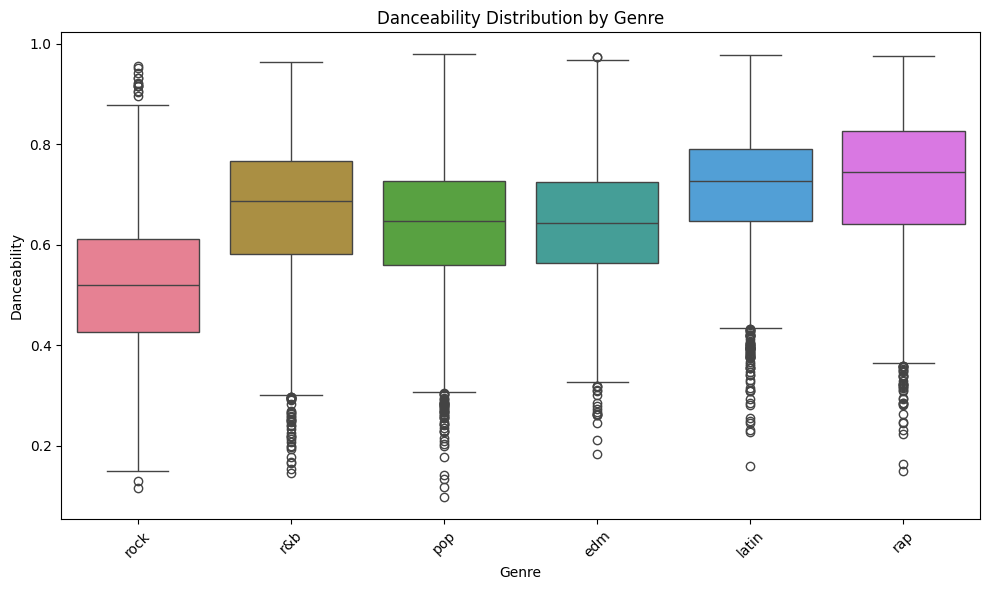

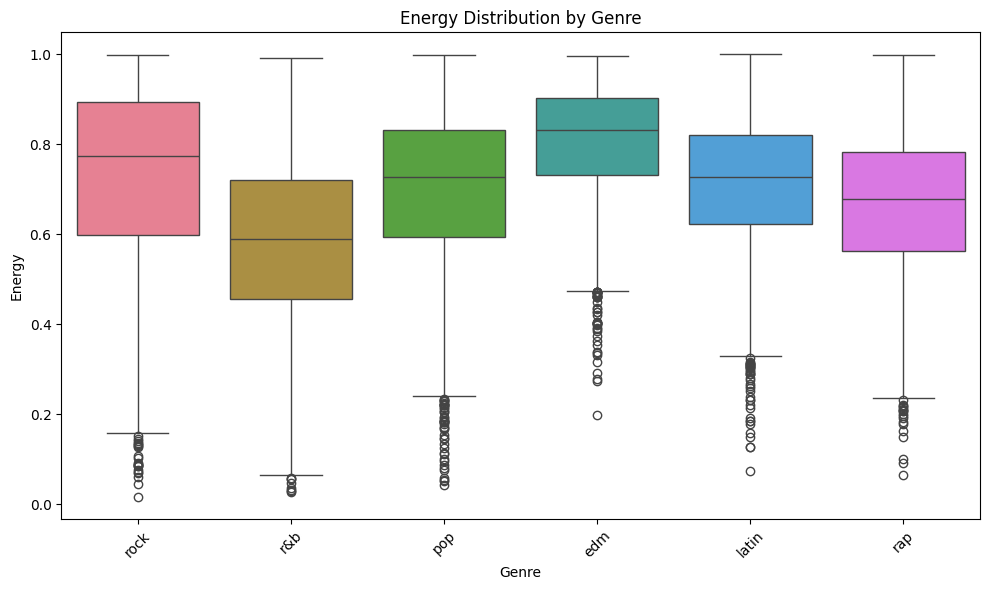

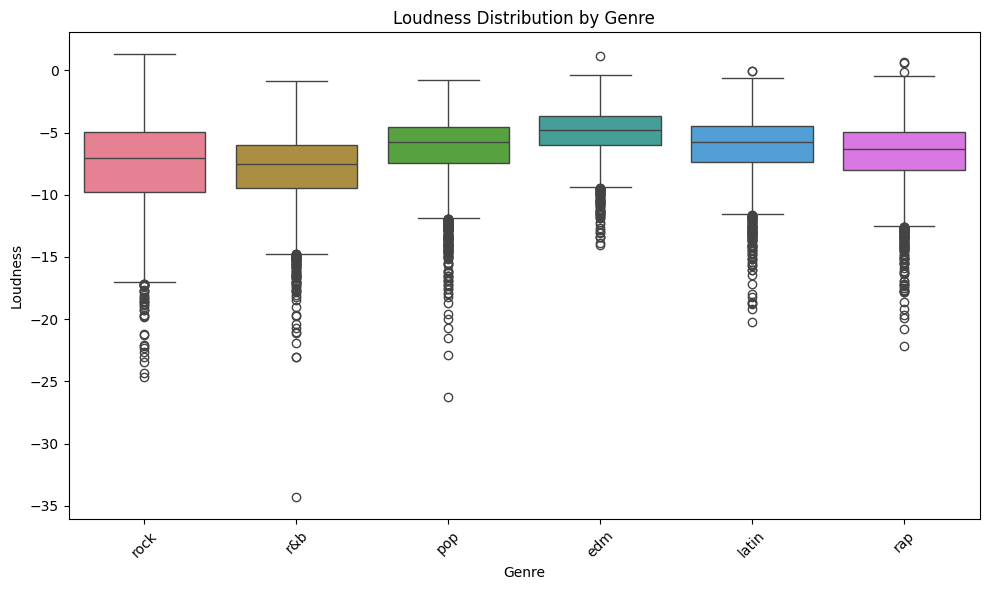

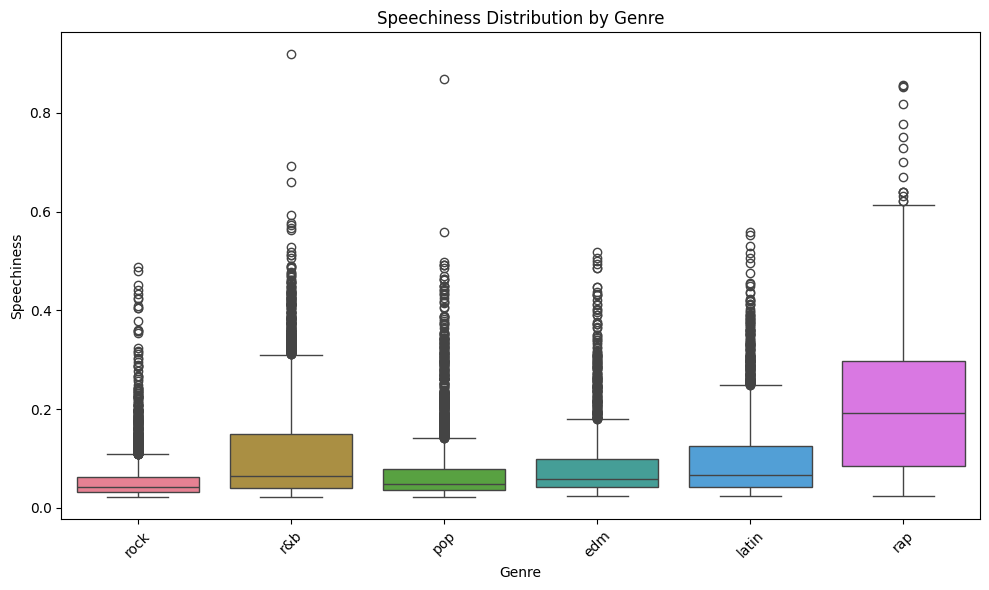

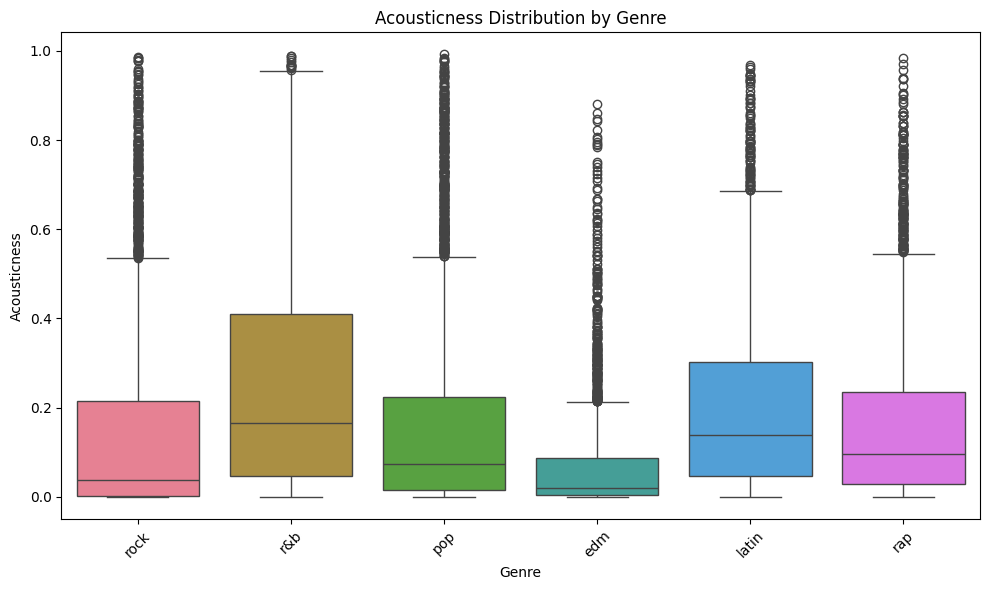

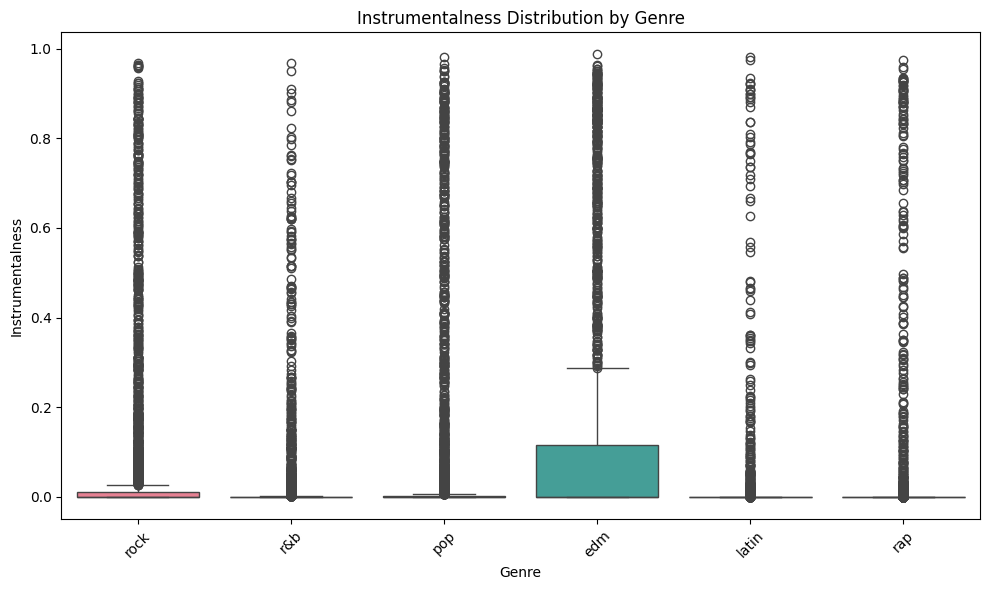

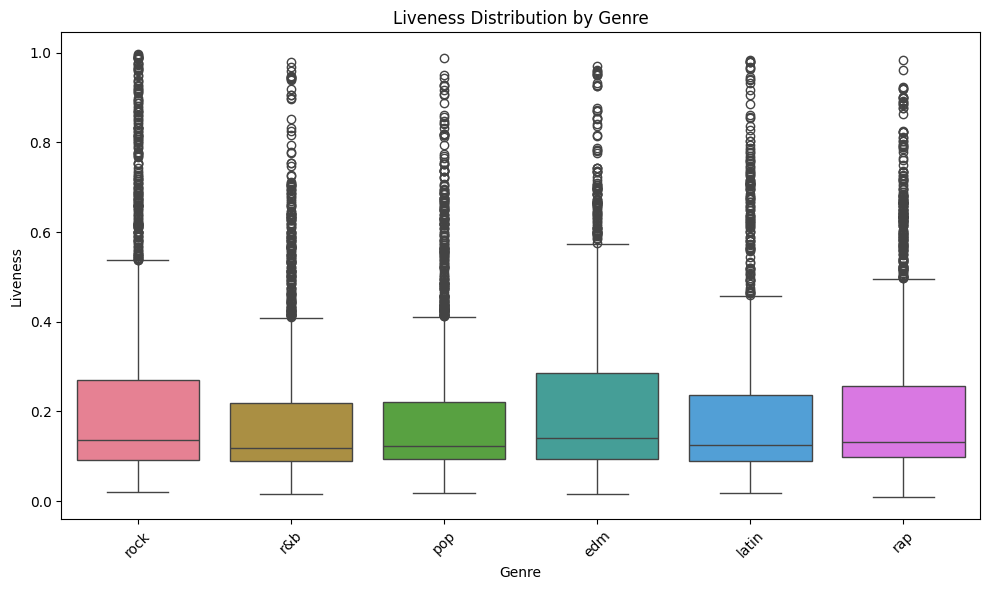

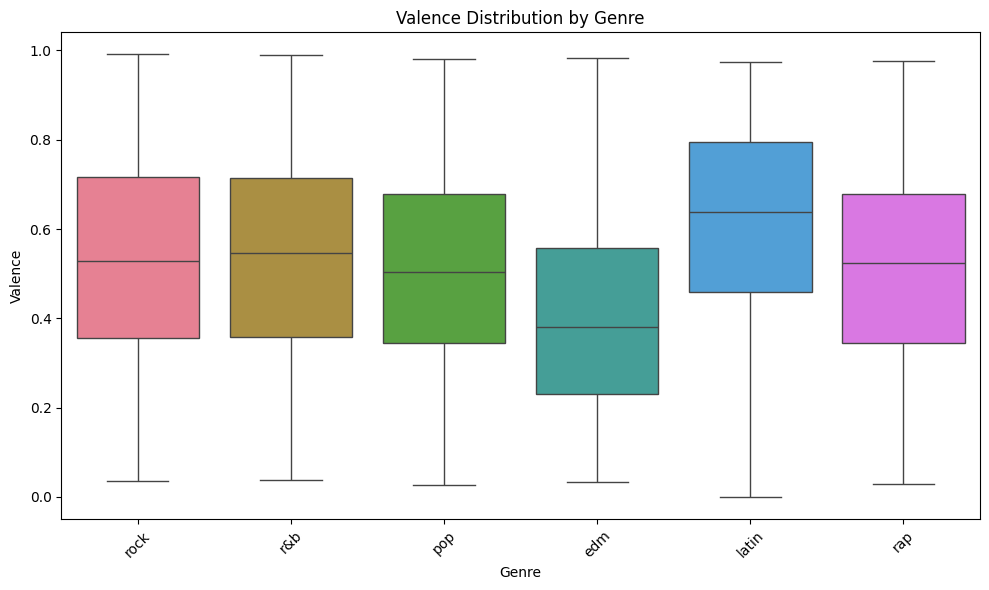

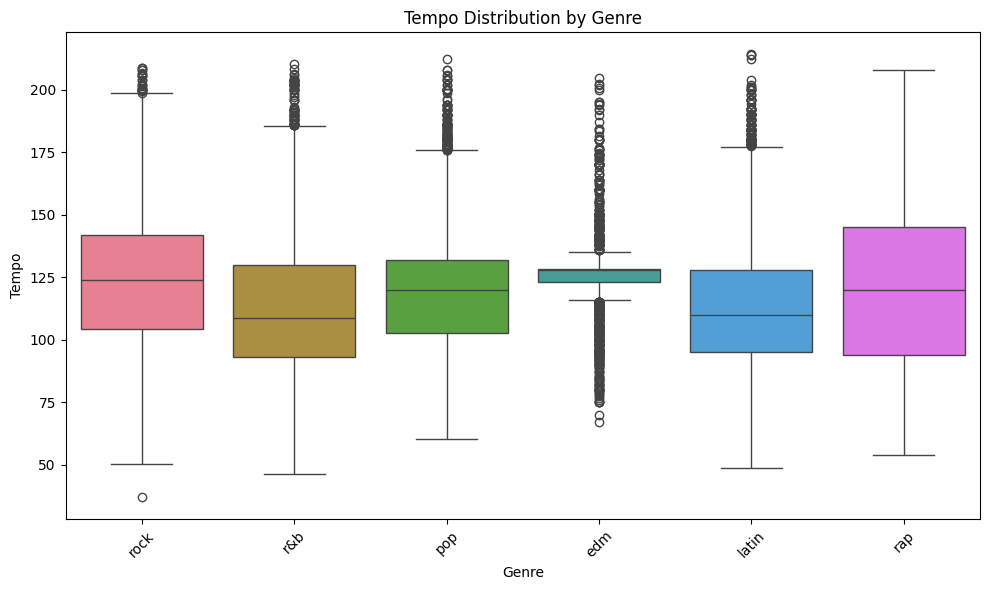

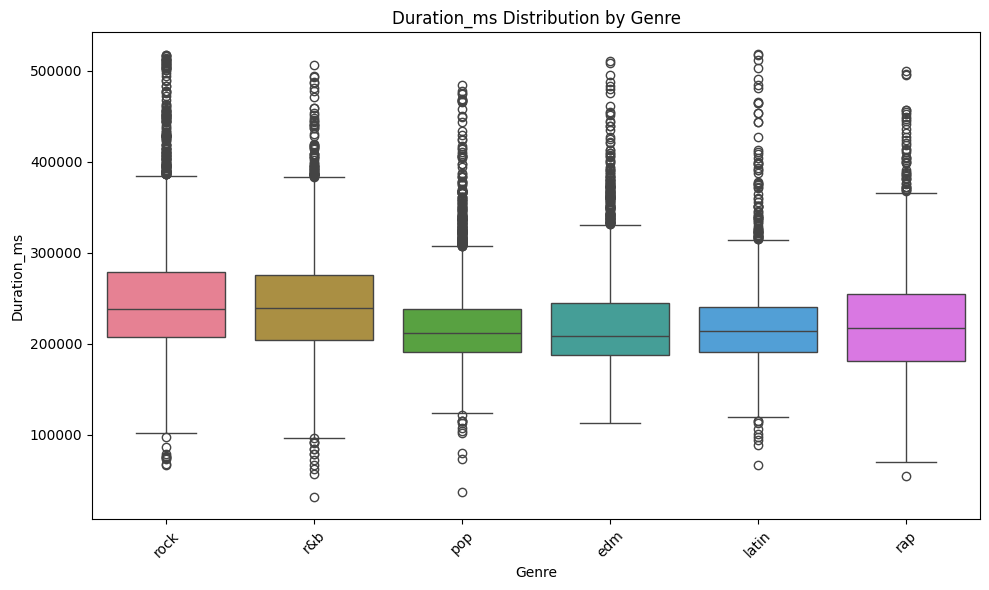

In [20]:
unique_genres = df['playlist_genre'].unique()

for feature in audio_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='playlist_genre', y=feature, hue="playlist_genre")
    plt.title(f'{feature.capitalize()} Distribution by Genre')
    plt.xlabel('Genre')
    plt.ylabel(feature.capitalize())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

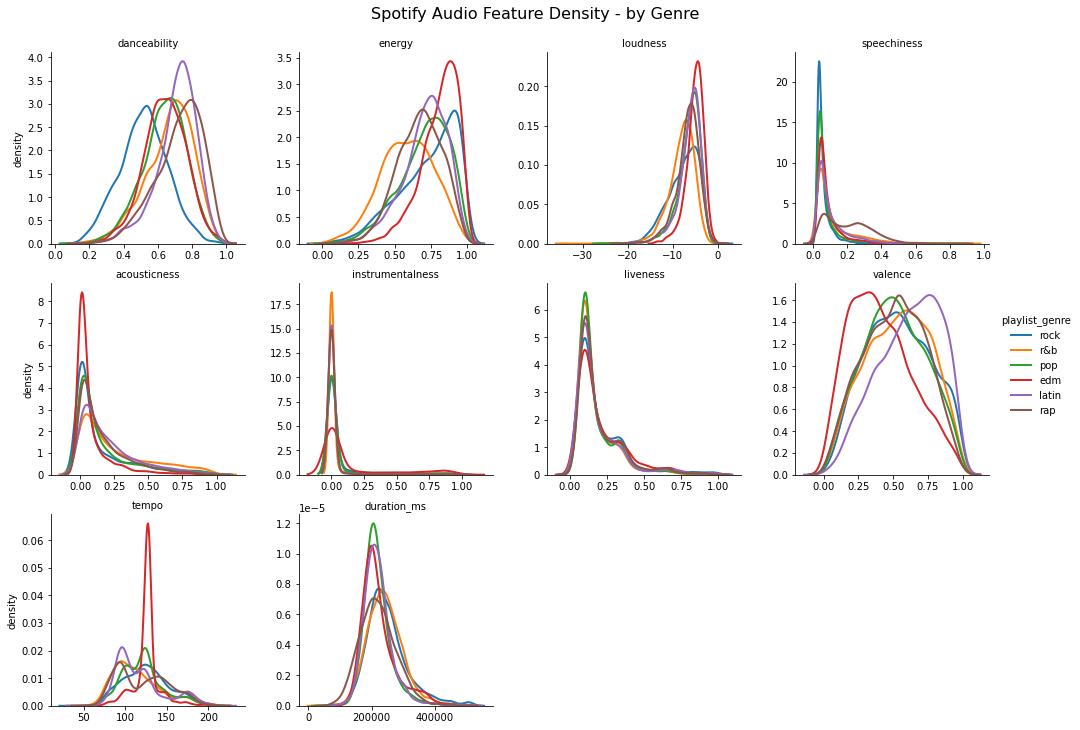

In [ ]:
# Set up the grid for plotting
grid = sns.FacetGrid(
    pd.melt(df, id_vars='playlist_genre', value_vars=audio_cols),
    col="variable", hue="playlist_genre", col_wrap=4, sharex=False, sharey=False, height=3.5
)

grid.map(sns.kdeplot, "value", fill=False, common_norm=False, linewidth=2)
grid.add_legend()
grid.set_titles("{col_name}")
grid.set_axis_labels("", "density")
plt.subplots_adjust(top=0.92)
grid.fig.suptitle("Spotify Audio Feature Density - by Genre", fontsize=16)
plt.show()

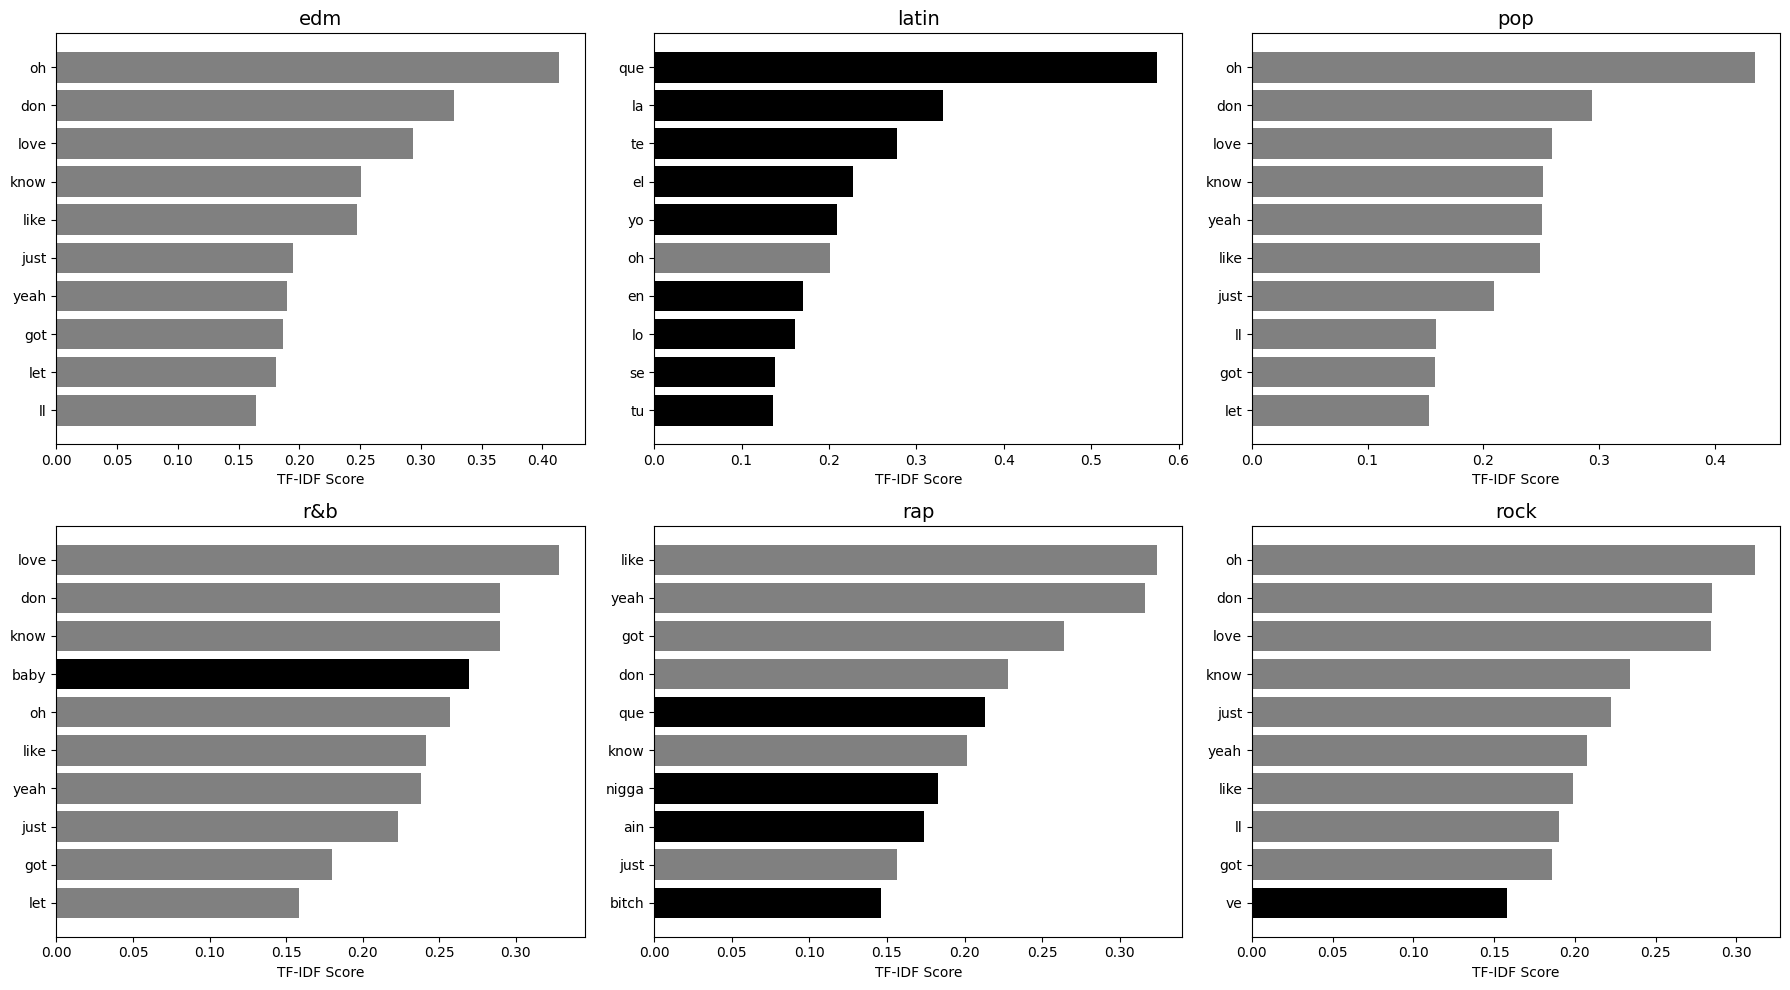

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Group lyrics per genre
genre_lyrics = df.groupby('playlist_genre')['lyrics'].apply(lambda x: ' '.join(x.dropna().astype(str)))
genres = genre_lyrics.index.tolist()

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(genre_lyrics)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=genres, columns=vectorizer.get_feature_names_out())

# Step 1: Get top N words per genre
top_n = 10
top_words_by_genre = {}
word_count_in_top = defaultdict(int)

for genre in tfidf_df.index:
    top_words = tfidf_df.loc[genre].sort_values(ascending=False).head(top_n)
    top_words_by_genre[genre] = top_words
    for word in top_words.index:
        word_count_in_top[word] += 1

# Step 2: Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False)
axes = axes.flatten()

for ax, (genre, top_words) in zip(axes, top_words_by_genre.items()):
    colors = ['black' if word_count_in_top[word] <= 2 else 'gray' for word in top_words.index]
    ax.barh(top_words.index[::-1], top_words.values[::-1], color=colors[::-1])
    ax.set_title(f"{genre}", fontsize=14)
    ax.set_xlabel("TF-IDF Score")
    ax.tick_params(axis='y', labelsize=10)

# Hide any unused subplots
for i in range(len(top_words_by_genre), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
